In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from tensorflow.keras.applications import DenseNet169

In [2]:
print(f'Using Keras version {tf.keras.__version__}')
print(f'Using TensorFlow version {tf.__version__}')

Using Keras version 3.6.0
Using TensorFlow version 2.16.2


In [3]:
# load the data and print some important information about it
X_orig = np.load('X.npy')
Y_orig = np.load('Y.npy')

# resizing for the gradients loss fn
Y_shape = Y_orig.shape
Y_orig = np.resize(Y_orig, (Y_shape[0], Y_shape[1], Y_shape[2], 1))

X_orig = X_orig/255

X_train, X_test = X_orig, None
Y_train, Y_test = Y_orig, None

print ("number of training examples = " + str(X_train.shape[0]))

#print ("number of test examples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

# set the max depth value for the loss fn 
MAX_DEPTH = np.max(Y_train) - np.min(Y_train)
print(f'MAX_DEPTH = {MAX_DEPTH}')

# set the cmap
cmap='plasma_r'

number of training examples = 9555
X_train shape: (9555, 96, 128, 3)
Y_train shape: (9555, 96, 128, 1)
MAX_DEPTH = 9870


Text(0.5, 1.0, 'Depth Image')

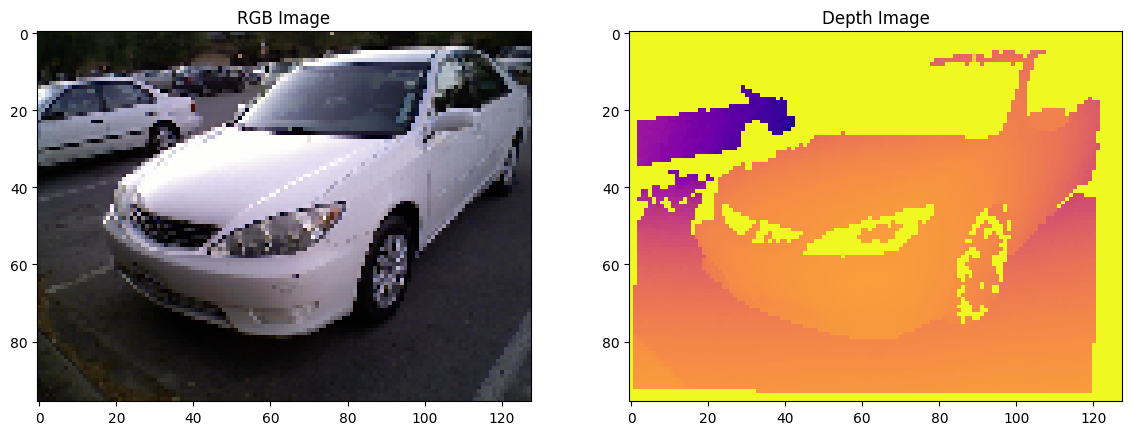

In [4]:
# look at various images

image_num = 16
fig, arr = plt.subplots(1, 2, figsize=(14, 7))
arr[0].imshow(X_train[image_num])
arr[0].set_title('RGB Image')
arr[1].imshow(Y_train[image_num], cmap=cmap)
arr[1].set_title('Depth Image')

### U NET ARCHITECHTURE ###

1. Contracting Block (downsample/encode) --> using transfer learning from DenseNet169
2. Skip connection (Concatenation)
3. Expanding Block (upsample/decode)
4. Final Feature Mapping (1x1 conv)

Used the framework from https://arxiv.org/abs/1812.11941

In [5]:
def UpScaleBlock(expansive_input, concat_layer, concat=True, n_filters=32):
    '''
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- input to be upsampled 
        concat_layer -- skip connection from the previous layer 
        concat (bool) -- whether or not to include the skip 
        n_filters -- # of filters 
    Returns:
        reluB -- upsampled relu output tensor
    ''' 
    
    up = tfl.UpSampling2D(size=(2, 2), interpolation='bilinear')(expansive_input)
    if concat:
        concatenated = tfl.concatenate([up, concat_layer], axis=-1)
        convA = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(concatenated)
    else:
        convA = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same')(up)
    reluA = tfl.LeakyReLU(negative_slope=0.2)(convA)
    convB = tfl.Conv2D(n_filters, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(reluA)
    reluB = tfl.LeakyReLU(negative_slope=0.2)(convB)

    return reluB

In [14]:
def loss_function(y_true, y_pred, lmbda=0.1, max_depth_value=MAX_DEPTH):
    '''
    Custom loss Fn

    Arguments:
        y_true, y_pred -- according to tf, ground truth and model prediction 
        lmbda -- MAE loss weight (0.1 default)
        max_depth_value -- max depth occurring anywhere in the image
    Returns 
        Weighted sum of the 3 loss terms
    ''' 

    # point-wise depth loss (MAE term) 
    l_MAE = K.mean(K.abs(y_pred - y_true), axis=-1)

    # gradient loss
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # l_ssim term 
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, max_depth_value)) * 0.5, 0, 1)

    return l_ssim + K.mean(l_edges) + (lmbda * K.mean(l_MAE))

In [7]:
def M_Unet(input_size=(96, 128, 3), n_filters=32, fine_tune=False, fine_tune_at=None):
    '''
    Transfer learning model. Call the base model DenseNet169, feed its output to our upsampling layers
    
    Arguments:
        inputs_size -- size of input 
        n_filters -- # of filters
        fine_tune (bool) -- whether to unlock layers of the base for fine tuning 
        fine_tune_at (int) -- how many layers to unlock. ignored if fine_tune=False
    Returns: 
        tf.keras.Model instance
    '''

    # load the base model and freeze it 
    inputs = tfl.Input(input_size)
    
    base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=input_size, input_tensor=inputs)
    base_model.trainable=False

    # option to fine tune the model
    if fine_tune:
        base_model.trainable=True
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False 

    # grab the names of the concat layers 
    concat_layers = ['pool1', 'pool2_pool', 'pool3_pool', 'conv1_relu']
    
    x = base_model(inputs, training=False)
    
    bottleneck = tfl.Conv2D(n_filters*16, kernel_size=1, padding="same")(x)
    ublock1 = UpScaleBlock(x, base_model.get_layer(concat_layers[2]).output, n_filters=n_filters*8)
    ublock2 = UpScaleBlock(ublock1, base_model.get_layer(concat_layers[1]).output, n_filters=n_filters*4)
    ublock3 = UpScaleBlock(ublock2, base_model.get_layer(concat_layers[0]).output, n_filters=n_filters*2)
    ublock4 = UpScaleBlock(ublock3, base_model.get_layer(concat_layers[3]).output, n_filters=n_filters)
    ublock5 = UpScaleBlock(ublock4, None, concat=False)

    outputs = tfl.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='linear')(ublock5)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
    

In [8]:
# grab the model and print its summary
model = M_Unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 96, 128, 3)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 102, 134, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 48, 64, 64)        │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 48, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 48, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 50, 66, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 24, 32, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 24, 32, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 24, 32, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 24, 32, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 24, 32, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 24, 32, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 24, 32, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 24, 32, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 18,459,489 (70.42 MB)

 Trainable params: 5,816,609 (22.19 MB)

 Non-trainable params: 12,642,880 (48.23 MB)

In [9]:
# compile the model with a learning rate decay scheduler
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=100, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, weight_decay=0.001, amsgrad=True)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

In [27]:
EPOCHS = 8
BATCH_SIZE = 16 

# save the model every epoch 
checkpoint_path = ".tf_checkpoints/checkpoint-{epoch:04d}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=False, save_freq='epoch')

# train the model
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/8
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 218.1898 - mae: 453.2347
Epoch 1: saving model to .tf_checkpoints/checkpoint-0001.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 795s 1s/step - loss: 218.1901 - mae: 453.2346
Epoch 2/8
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 215.5424 - mae: 437.8680
Epoch 2: saving model to .tf_checkpoints/checkpoint-0002.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - loss: 215.5433 - mae: 437.8668
Epoch 3/8
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 215.0672 - mae: 425.9927
Epoch 3: saving model to .tf_checkpoints/checkpoint-0003.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - loss: 215.0663 - mae: 425.9913
Epoch 4/8
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 210.9248 - mae: 407.6956
Epoch 4: saving model to .tf_checkpoints/checkpoint-0004.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - loss: 210.9276 - mae: 407.6994
Epoch 5/8
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 210.4253 - mae: 399.0744
Epoch 5: saving model to .tf_chec

In [29]:
# model tragically crashed at epoch 2. lets see if we can load it 
new_model = M_Unet()
new_model.load_weights(".tf_checkpoints/checkpoint-0008.keras")

In [35]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=100, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, weight_decay=0.001, amsgrad=True)
new_model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

In [36]:
EPOCHS = 16
BATCH_SIZE = 16 

# save the model every epoch 
checkpoint_path = ".tf_checkpoints/checkpoint-{epoch:04d}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=False, save_freq='epoch')

# train the model
history = new_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, initial_epoch=8, callbacks=[checkpoint_callback])

Epoch 9/16
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 209.8821 - mae: 377.4962
Epoch 9: saving model to .tf_checkpoints/checkpoint-0009.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - loss: 209.8789 - mae: 377.4814
Epoch 10/16
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 208.9220 - mae: 362.5546
Epoch 10: saving model to .tf_checkpoints/checkpoint-0010.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - loss: 208.9172 - mae: 362.5455
Epoch 11/16
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 205.9029 - mae: 352.9639
Epoch 11: saving model to .tf_checkpoints/checkpoint-0011.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 696s 1s/step - loss: 205.9005 - mae: 352.9574
Epoch 12/16
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 200.6557 - mae: 338.9457
Epoch 12: saving model to .tf_checkpoints/checkpoint-0012.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - loss: 200.6599 - mae: 338.9521
Epoch 13/16
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 200.6755 - mae: 333.0912
Epoch 13: saving mode

In [59]:
newer_model = M_Unet()
newer_model.load_weights(".tf_checkpoints/checkpoint-0016.keras")
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=100, decay_rate=0.99, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, weight_decay=0.001, amsgrad=True)
newer_model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

In [60]:
EPOCHS = 20
BATCH_SIZE = 16 

# save the model every epoch 
checkpoint_path = ".tf_checkpoints/checkpoint-{epoch:04d}.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_weights_only=False, save_freq='epoch')

# train the model
history = new_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, initial_epoch=16, callbacks=[checkpoint_callback])

Epoch 17/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 197.8254 - mae: 311.3104
Epoch 17: saving model to .tf_checkpoints/checkpoint-0017.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 785s 1s/step - loss: 197.8235 - mae: 311.3049
Epoch 18/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 197.7832 - mae: 306.2497
Epoch 18: saving model to .tf_checkpoints/checkpoint-0018.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 1041s 2s/step - loss: 197.7799 - mae: 306.2443
Epoch 19/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 193.6896 - mae: 297.4982
Epoch 19: saving model to .tf_checkpoints/checkpoint-0019.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - loss: 193.6919 - mae: 297.5030
Epoch 20/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 193.9799 - mae: 293.5573
Epoch 20: saving model to .tf_checkpoints/checkpoint-0020.keras
598/598 ━━━━━━━━━━━━━━━━━━━━ 1083s 2s/step - loss: 193.9796 - mae: 293.5551


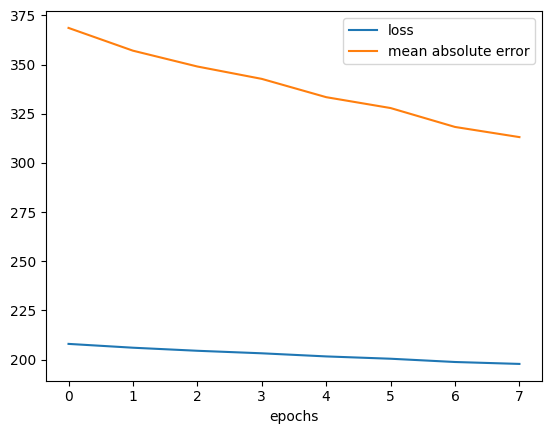

In [40]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['mae'], label='mean absolute error')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [70]:
def show_predictions(images, ground_truth, num=1):
    '''
    Cute wrapper to pick an image, show its GT and prediction. Use on train or test set

    Arguments:
    images -- RGB image 
    ground_truth -- GT depth 
    num -- index of the image you want to predict 

    TODO: add functionality for showing predictions of images without GT 

    Returns:
    Nothing. Shows plt.figure on call
    '''
    
    test_predict = np.reshape(images[num], (1, 96, 128, 3))
    test_truth = np.reshape(ground_truth[num], (1, 96, 128, 1))
    prediction = new_model.predict(test_predict)

    fig, arr = plt.subplots(1, 3, figsize=(14, 7))
    arr[0].imshow(images[num])
    arr[0].set_title('Original Image')

    arr[1].imshow(ground_truth[num], cmap=cmap, vmax=np.max(ground_truth[num]), vmin=np.min(ground_truth[num]))
    arr[1].set_title('Ground Truth Map')
    
    arr[2].imshow(prediction[0, :, :, :], cmap=cmap)
    arr[2].set_title('Predicted Map')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


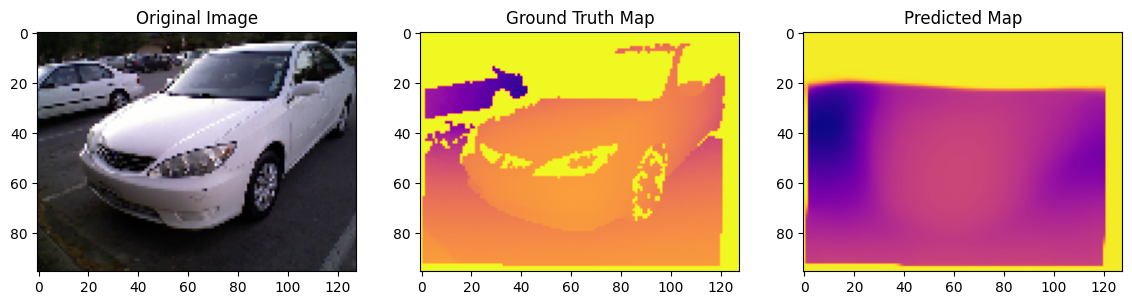

In [73]:
show_predictions(X_train, Y_train, num=16)